In [1]:
# Installing libraries and demo data
import os
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

import mne
import mne_nirs

# Cool IO for reading TD-NIRS stuff
from mne.io import read_raw_snirf

from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

from nilearn.plotting import plot_design_matrix

C:\Python39\lib\site-packages\nilearn\glm\__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
C:\Python39\lib\site-packages\nilearn\datasets\__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
fnirs_raw_dir = "C:\\Users\\esben\\Desktop\\BCI\\Bachelor\\Griffiths\\KernelFlow-Dev\\data\\2020.4-PLT_02ad2be_3.snirf"
raw_intensity = read_raw_snirf(fnirs_raw_dir).load_data()
raw_intensity.resample(0.7)

Loading C:\Users\esben\Desktop\BCI\Bachelor\Griffiths\KernelFlow-Dev\data\2020.4-PLT_02ad2be_3.snirf
Reading 0 ... 3424  =      0.000 ...   479.702 secs...


<RawSNIRF | 2020.4-PLT_02ad2be_3.snirf, 13236 x 336 (478.6 s), ~51.5 MB, data loaded>

In [5]:
indices = [i for i, s in enumerate(raw_intensity.ch_names) if ' moment0' in s]

bad_chan=[]
for xx in range(len(indices)):
  bad_chan.append(raw_intensity.ch_names[int(indices[xx])])

raw_intensity.info['bads'] =  bad_chan
raw_intensity

<RawSNIRF | 2020.4-PLT_02ad2be_3.snirf, 13236 x 336 (478.6 s), ~51.6 MB, data loaded>

In [3]:

raw_intensity.annotations.delete(raw_intensity.annotations.description == '15.0')

In [4]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od)

ValueError: picks ('fnirs_cw_amplitude') could not be interpreted as channel names (no channel "fnirs_cw_amplitude"), channel types (no type "None"), or a generic type (just "all" or "data")

In [ ]:
ic(mne.preprocessing.nirs.optical_density)
short_chs = get_short_channels(raw_haemo)
raw_haemo = get_long_channels(raw_haemo)

ic| mne.preprocessing.nirs.optical_density: <function optical_density at 0x000001DA69FA7DC0>


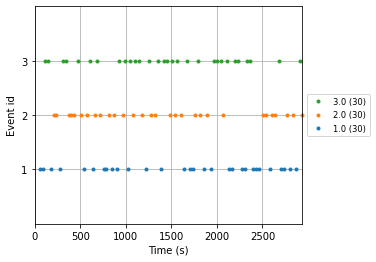

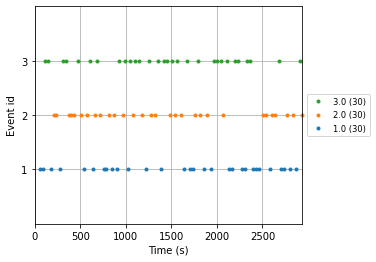

In [ ]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info['sfreq'])

Used Annotations descriptions: ['1.0', '2.0', '3.0']


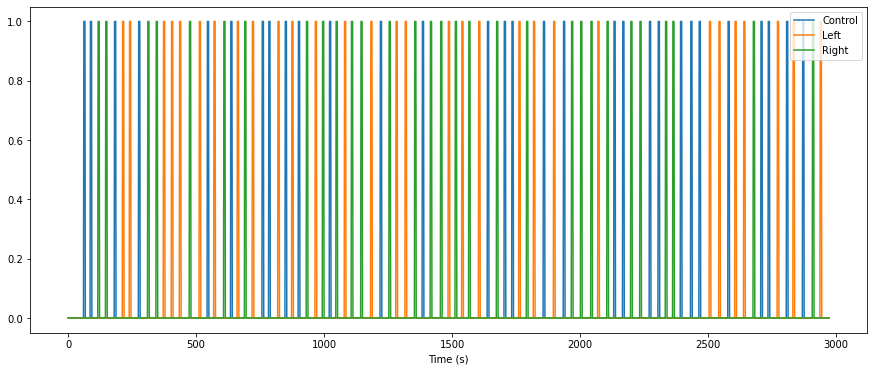

In [ ]:
s = mne_nirs.experimental_design.create_boxcar(raw_haemo)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.plot(raw_haemo.times, s, axes=axes)
plt.legend(["Control", "Left", "Right"], loc="upper right")
plt.xlabel("Time (s)");

In [ ]:
design_matrix = make_first_level_design_matrix(raw_haemo,
                                               drift_model='cosine',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=5.0)

In [ ]:
design_matrix["ShortHbO"] = np.mean(short_chs.copy().pick(
                                    picks="hbo").get_data(), axis=0)

design_matrix["ShortHbR"] = np.mean(short_chs.copy().pick(
                                    picks="hbr").get_data(), axis=0)

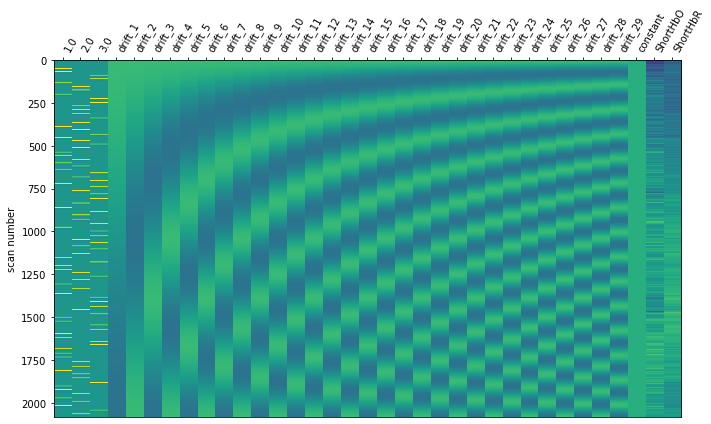

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6), nrows=1, ncols=1)
fig = plot_design_matrix(design_matrix, ax=ax1)

Used Annotations descriptions: ['1.0', '2.0', '3.0']


Text(0, 0.5, 'Amplitude')

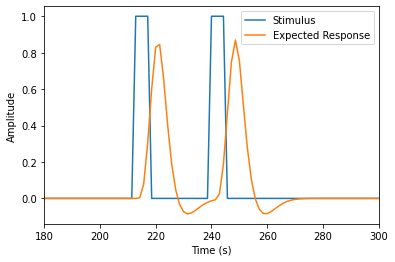

In [ ]:
s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=5.0)
plt.plot(raw_intensity.times, s[:, 1])
plt.plot(design_matrix['2.0'])
plt.xlim(180, 300)
plt.legend(["Stimulus", "Expected Response"])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

In [ ]:
data_subset = raw_haemo.copy().pick(picks=range(2))
glm_est = run_glm(data_subset, design_matrix)

In [ ]:
glm_est

GLM Results for 2 channels

In [ ]:
glm_est.copy().pick('S1_D1 hbr')

GLM Results for 1 channels

In [ ]:
glm_est.MSE()

[3.635950128126044e-11, 9.482010775760915e-12]

In [ ]:
glm_est.copy().pick('S1_D1 hbr').MSE()

[9.482010775760915e-12]

In [ ]:
glm_est.to_dataframe().head(9)

variable,ch_name,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant
0,S1_D1 hbo,1.0,35.0,3.635950e-11,5.703922e-01,1.271854e-06,0.572874,7.286122e-07,1,1,hbo,False
1,S1_D1 hbo,2.0,35.0,3.635950e-11,8.464418e-06,1.289978e-06,5.211297,6.722461e-06,1,1,hbo,True
2,S1_D1 hbo,3.0,35.0,3.635950e-11,7.547857e-16,1.294997e-06,13.935896,1.804694e-05,1,1,hbo,True
3,S1_D1 hbo,ShortHbO,35.0,3.635950e-11,5.988346e-39,1.253564e-02,68.802806,8.624875e-01,1,1,hbo,True
4,S1_D1 hbo,ShortHbR,35.0,3.635950e-11,2.051290e-19,7.976514e-02,-18.187656,-1.450741e+00,1,1,hbo,True
5,S1_D1 hbo,constant,35.0,3.635950e-11,5.227182e-02,2.943860e-07,-2.009249,-5.914949e-07,1,1,hbo,False
6,S1_D1 hbo,drift_1,35.0,3.635950e-11,6.333101e-25,3.084314e-05,26.818114,8.271549e-04,1,1,hbo,True
7,S1_D1 hbo,drift_10,35.0,3.635950e-11,8.211815e-07,1.215036e-05,5.979676,7.265522e-05,1,1,hbo,True
8,S1_D1 hbo,drift_11,35.0,3.635950e-11,4.069713e-01,1.242152e-05,0.839347,1.042596e-05,1,1,hbo,False


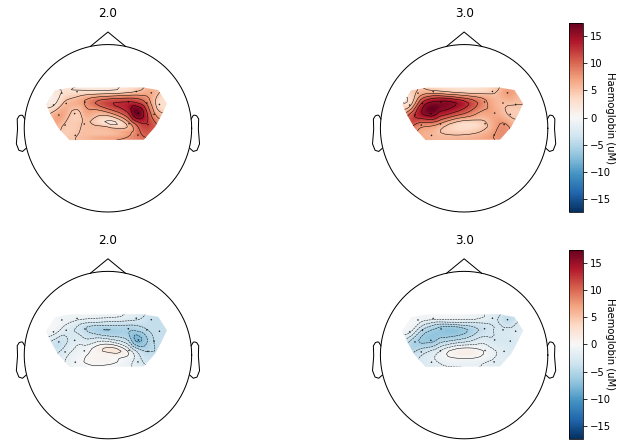

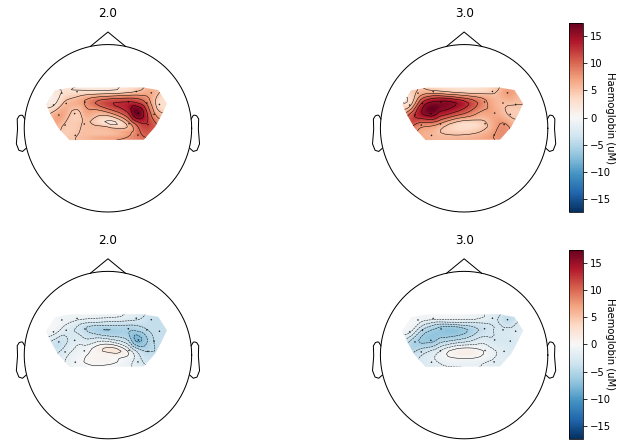

In [ ]:
glm_est = run_glm(raw_haemo, design_matrix)
glm_est.plot_topo(conditions=['2.0', '3.0'])

Text(0.5, 1.0, 'Hemispheres plotted independently')

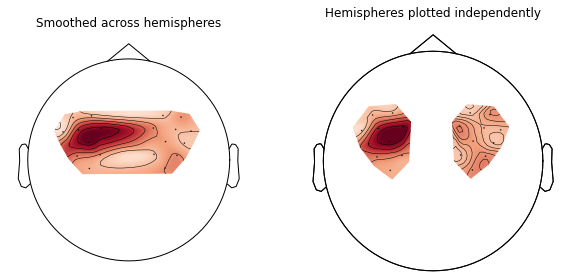

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), gridspec_kw=dict(width_ratios=[0.92, 1]))

glm_hbo = glm_est.copy().pick(picks="hbo")
conditions = ['3.0']

glm_hbo.plot_topo(axes=axes[0], colorbar=False, conditions=conditions)

glm_hbo.copy().pick(picks=range(10)).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vmin=-16, vmax=16)
glm_hbo.copy().pick(picks=range(10, 20)).plot_topo(conditions=conditions, axes=axes[1], colorbar=False, vmin=-16, vmax=16)

axes[0].set_title("Smoothed across hemispheres")
axes[1].set_title("Hemispheres plotted independently")

In [ ]:
glm_est.copy().surface_projection(condition="3.0", view="dorsal", chroma="hbo")

NameError: name 'glm_est' is not defined